Introduction:
- provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your report
- clearly state the question you tried to answer with your project
identify and fully describe the dataset that was used to answer the question

Methods & Results
- describe the methods you used to perform your analysis from beginning to end that narrates the analysis code.
your report should include code which:
- loads data 
- wrangles and cleans the data to the format necessary for the planned analysis
- performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 
- creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
- performs the data analysis
- creates a visualization of the analysis 
* note: all figures should have a figure number and a legend

In [51]:
library(tidyverse)

url <- "https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz"

players <- read_csv(url)
# players

url2 <- "https://drive.google.com/uc?export=download&id=14O91N5OlVkvdGxXNJUj5jIsV5RexhzbB"
sessions <- read_csv(url2)
# sessions

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [57]:
sessions_time <- sessions |>
    mutate(start_time = as.POSIXct(start_time, format = "%d/%m/%Y %H:%M")) |>
    mutate(end_time = as.POSIXct(end_time, format = "%d/%m/%Y %H:%M")) |>
    mutate(time_difference = as.numeric(difftime(end_time, start_time, units = "mins")))
# calculates the time spent playing in minutes

sessions_grouped <- sessions_time |>
    group_by(hashedEmail) |>
    summarise(number_of_sessions = n())
# calculates the number of sessions a player has played

players_neat <- players |>
    mutate(experience= factor(experience, 
                                 levels = c("Beginner", "Amateur", "Regular", "Pro", "Veteran"), 
                                 labels = c(1, 2, 3, 4, 5))) |>
    mutate(experience_numeric = as.numeric(experience), subscribe = factor(subscribe)) |>
    select(-individualId, -organizationName)

# creates extra column where experience is a numeric, so it can be plotted for our visualization
# changes experience to a factor, where
#                                 1: Beginner level
#                                 2: Amateur level
#                                 3: Regular level
#                                 4: Pro level
#                                 5: Veteran level
# removes the two uneccessary columns for our analysis
           
combined <- players_neat |>
   right_join(sessions_grouped, by = "hashedEmail") |>
    select(-experience_numeric, -name, -hashedEmail, -age)

combined_example <- combined |>
    slice_head(n = 6)

combined_example

experience,subscribe,played_hours,gender,number_of_sessions
<fct>,<fct>,<dbl>,<chr>,<int>
4,TRUE,30.3,Male,27
5,TRUE,3.8,Male,3
5,FALSE,0.0,Male,1
2,TRUE,0.7,Female,1
3,TRUE,0.1,Male,1
2,FALSE,0.0,Male,1


Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”


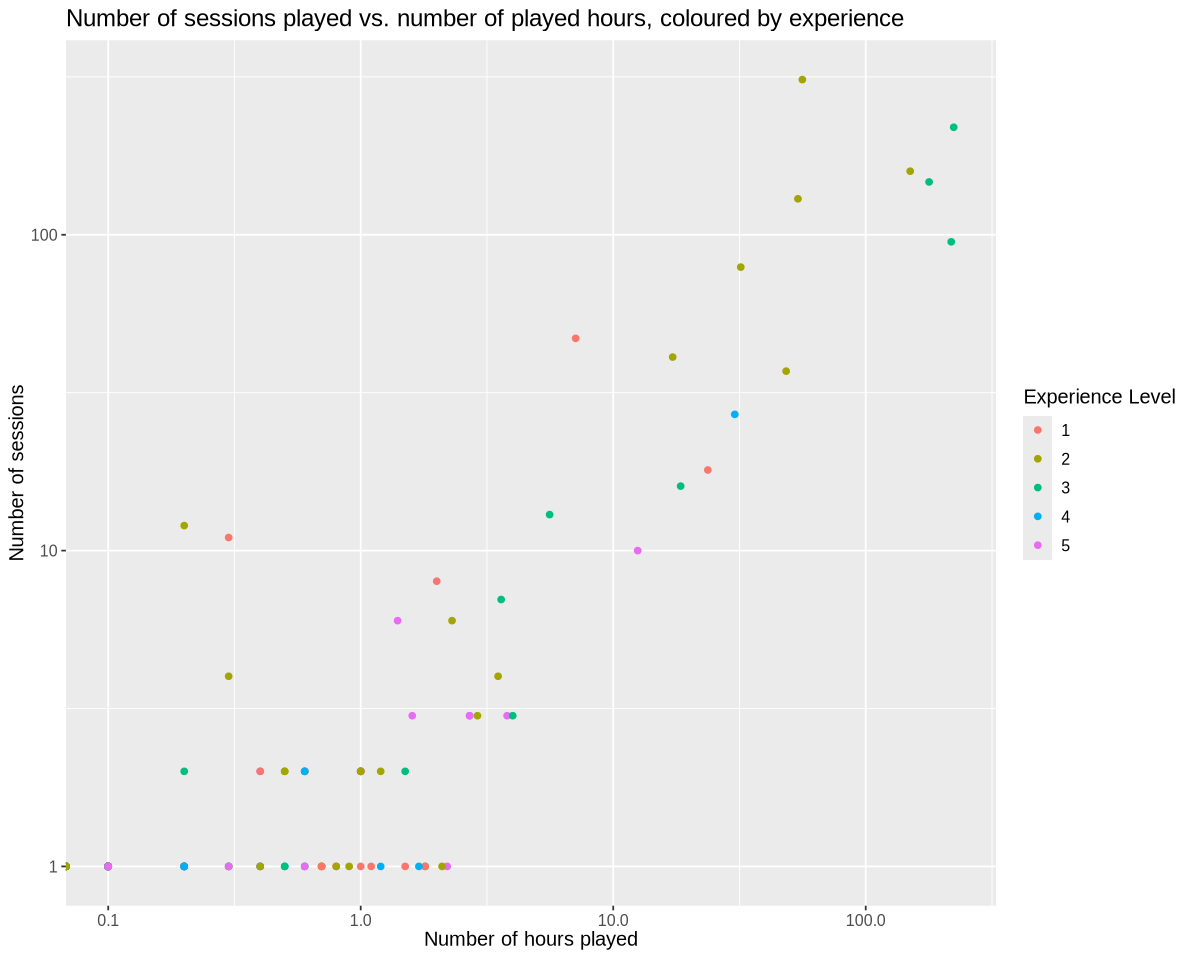

In [52]:
library(ggplot2)

options(repr.plot.height = 8, repr.plot.width = 10)

plot_experience <- combined |>
  ggplot(aes(x = played_hours, y = number_of_sessions, color = experience)) +
  geom_point() +
  labs(x = 'Number of hours played', 
       y = 'Number of sessions', 
       color = 'Experience Level',
        title = "Number of sessions played vs. number of played hours, coloured by experience") +
  scale_x_log10() +
  scale_y_log10() +
  theme(text = element_text(size = 12))

plot_experience

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”


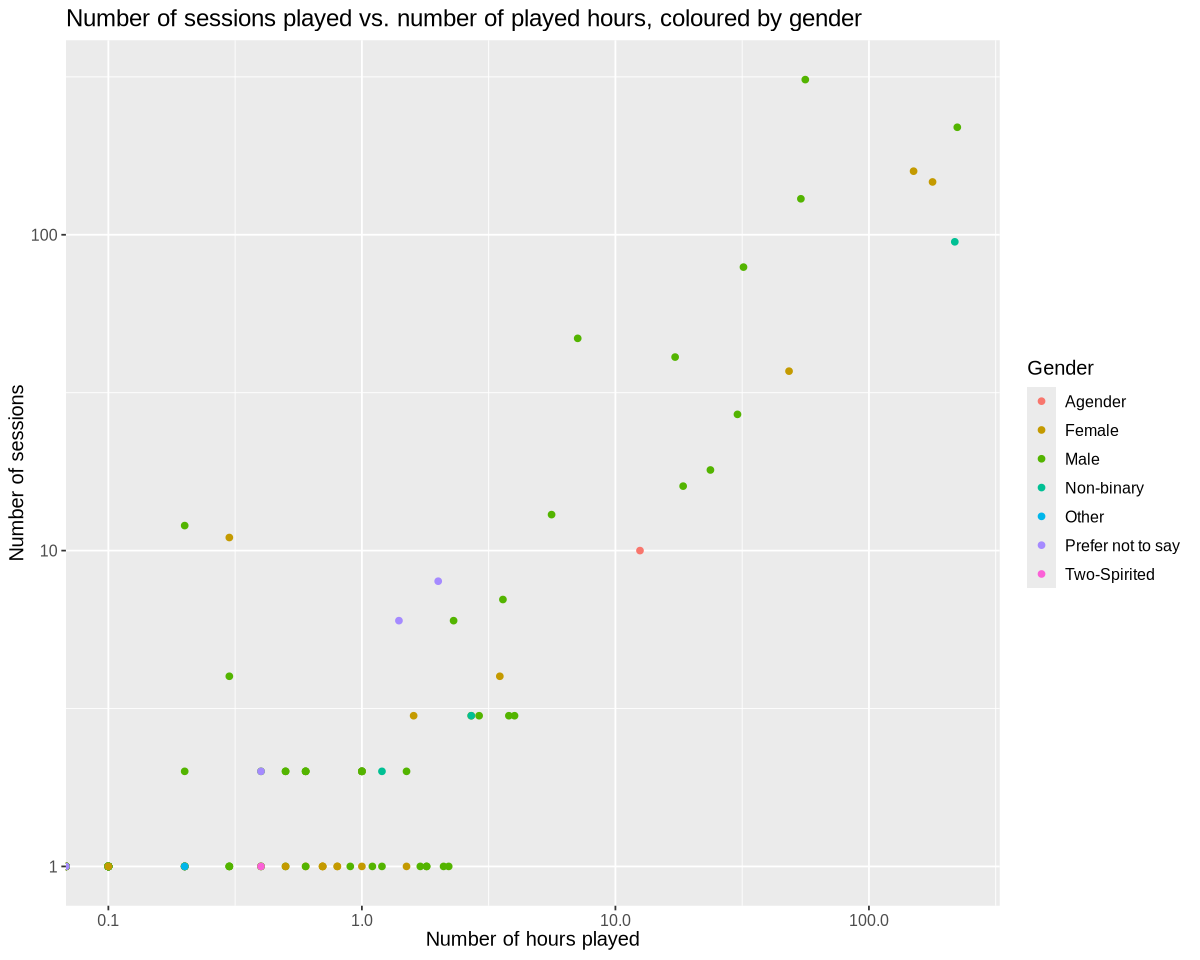

In [14]:
plot_gender <- combined |>
  ggplot(aes(x = played_hours, y = number_of_sessions, color = gender)) +
  geom_point() +
  labs(x = 'Number of hours played', 
       y = 'Number of sessions', 
       color = 'Gender',
        title = "Number of sessions played vs. number of played hours, coloured by gender") +
    scale_x_log10() +
  scale_y_log10() +
  theme(text = element_text(size = 12))
 options(repr.plot.height = 8, repr.plot.width = 10)
plot_gender

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”


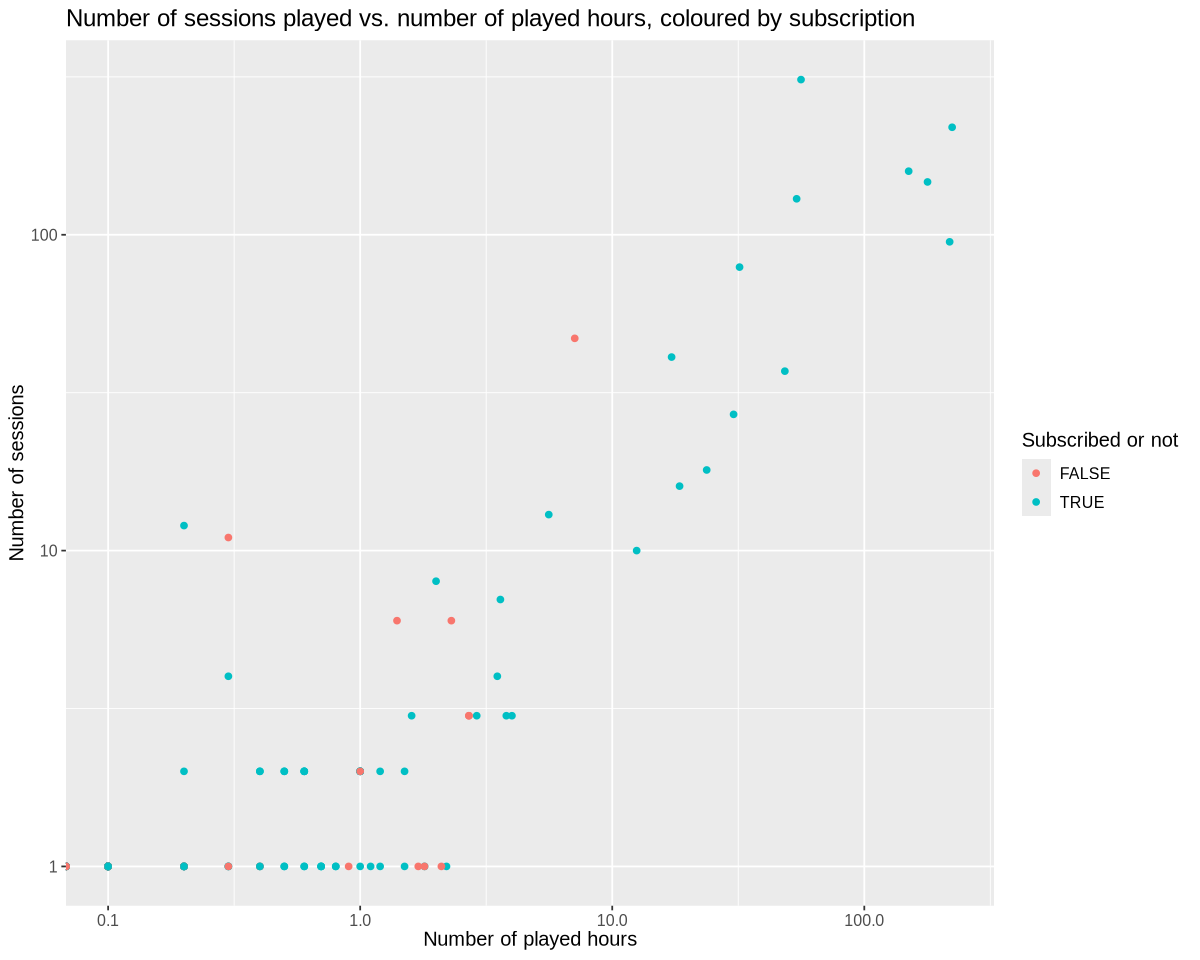

In [13]:
options(repr.plot.height = 8, repr.plot.width = 10)

plot_subscribe <- combined |>
  ggplot(aes(x = played_hours, y = number_of_sessions, color = subscribe)) +
  geom_point() +
  labs(x = 'Number of played hours', 
       y = 'Number of sessions', 
       color = 'Subscribed or not',
       title = "Number of sessions played vs. number of played hours, coloured by subscription") +
  scale_x_log10() +
  scale_y_log10() +
  theme(text = element_text(size = 12))

plot_subscribe

**Predictive Models**

Predictive model for experience

In [49]:
library(tidyverse)
library(tidymodels)

#sets seed
set.seed(1)

#creating prediction model based on experience
#splits data into training and testing
experience_split <- initial_split(combined, prop = 0.75, strata = experience)
experience_train <- training(experience_split)
experience_test <- testing(experience_split)

#creates model with multiple neighbors to create classification
experience_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                 set_engine("kknn") |>
                 set_mode("classification")

#creates recipe to scale predictors
exp_recipe <- recipe(experience ~ played_hours + number_of_sessions, data = experience_train) |>
                   step_scale(all_predictors()) |>
                   step_center(all_predictors())

#creates workflow
exp_workflow <- workflow() |>
                     add_recipe(exp_recipe) |>
                     add_model(experience_spec) 

# k values for neighbors
gridvals <- tibble(neighbors = seq(from = 1, to = 10))

#cross validation - 5 fold
exp_vfold <- vfold_cv(experience_train, v = 5, strata = experience)

# creates a table of metrics for each k value
exp_results <- exp_workflow |>
                        tune_grid(resamples = exp_vfold, grid = gridvals) |>
                        collect_metrics()

#filters table for accuracy and selects columns
clean_exp_results <- exp_results |>
    filter(.metric == "accuracy") |>
    select(neighbors, mean)

# clean_exp_results

#identifies neighbors with the highest accuracy value
choose_k_exp <- clean_exp_results |>
    arrange(mean) |>
    slice_max(mean, n=1) 

choose_k_exp


→ A | warning: ✖ No observations were detected in `truth` for level: 4.
               ℹ Computation will proceed by ignoring those levels.

There were issues with some computations   A: x1

There were issues with some computations   A: x1





neighbors,mean
<int>,<dbl>
5,0.1974888


In [54]:
# the highest accuracy is when k=5, therefore we will develop a model with neighbors = 5

#creates model with the k value as 5
exp_spec2 <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |>
       set_engine("kknn") |>
       set_mode("classification")

#creates a new workflow to fit the training data in
exp_fit <- workflow() |>
             add_recipe(exp_recipe) |>
             add_model(exp_spec2) |>
            fit(data = experience_train)


#predict the experience in the testing data with the trained workflow
exp_predictions <- predict(exp_fit, experience_test) |>
                        bind_cols(experience_test) 

#ensures that experience and .pred_class have the same amount of categories
exp_levels <- c("Beginner", "Amateur", "Regular", "Pro", "Veteran")


#creates metrics for testing set to obtain accuracy value
metrics_exp <- exp_predictions |>
                 # mutate(experience = factor(experience, levels = exp_levels),
                 #        .pred_class = factor(.pred_class, levels = exp_levels)) |>
                 metrics(truth = experience, estimate = .pred_class) |>
                 filter(.metric == "accuracy")

metrics_exp

#creates a confusion matrix for testing set
conf_mat_exp <- exp_predictions |>
        # mutate(experience = factor(experience, levels = exp_levels),
        #    .pred_class = factor(.pred_class, levels = exp_levels)) |>
        conf_mat(truth = experience, estimate = .pred_class)

conf_mat_exp


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.1818182


          Truth
Prediction 1 2 3 4 5
         1 1 5 1 2 6
         2 2 3 3 1 0
         3 1 1 1 0 0
         4 2 2 0 0 0
         5 0 0 1 0 1

Predictive model for gender

In [37]:
#sets seed
set.seed(1)

#creating prediction model based on gender
#splits data into training and testing
gender_split <- initial_split(combined, prop = 0.75, strata = gender)
gender_train <- training(gender_split)
gender_test <- testing(gender_split)

#creates model with multiple neighbors to create classification
gender_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                 set_engine("kknn") |>
                 set_mode("classification")

#creates recipe to scale predictors
gender_recipe <- recipe(gender ~ played_hours + number_of_sessions, data = gender_train) |>
                   step_scale(all_predictors()) |>
                   step_center(all_predictors())

#cross validation
gender_vfold <- vfold_cv(gender_train, v = 5, strata = gender)

#creates workflow
gender_workflow <- workflow() |>
                     add_recipe(gender_recipe) |>
                     add_model(gender_spec) 

# k values for neighbors
gridvals <- tibble(neighbors = seq(from = 1, to = 10))

# creates a table of metrics for each k value
gender_results <- gender_workflow |>
                        tune_grid(resamples = gender_vfold, grid = gridvals) |>
                        collect_metrics()

#filters and selects table
clean_gender_results <- gender_results |>
    filter(.metric == "accuracy") |>
    select(neighbors, mean)

#identifies neighbors with the highest accuracy value
choose_k_gender <- clean_gender_results |>
    arrange(mean) |>
    slice_max(mean, n=1) 

choose_k_gender

#creates a confusion matrix for testing set
conf_mat_exp <- exp_predictions |>
        # mutate(gender = factor(gender, levels = all_levels),
        #    .pred_class = factor(.pred_class, levels = all_levels)) |>
        conf_mat(truth = experience, estimate = .pred_class)

conf_mat_exp


→ A | warning: ✖ No observations were detected in `truth` for levels: Non-binary and Other.
               ℹ Computation will proceed by ignoring those levels.

There were issues with some computations   A: x1

→ B | warning: ✖ No observations were detected in `truth` for levels: Agender, Non-binary,
                 Other, and Two-Spirited.
               ℹ Computation will proceed by ignoring those levels.

There were issues with some computations   A: x1
There were issues with some computations   A: x1   B: x1

→ C | warning: ✖ No observations were detected in `truth` for levels: Agender, Other, Prefer
                 not to say, and Two-Spirited.
               ℹ Computation will proceed by ignoring those levels.

There were issues with some computations   A: x1   B: x1
→ D | error:   Failed to compute `roc_auc()`.
               Caused by error in `group[estimate]`:
               ! Can't subset columns that don't exist.
               ✖ Column `.pred_Other` doesn't exist.

There

neighbors,mean
<int>,<dbl>
7,0.6059942
8,0.6059942


          Truth
Prediction 1 2 3 4 5
         1 1 5 1 2 6
         2 2 3 3 1 0
         3 1 1 1 0 0
         4 2 2 0 0 0
         5 0 0 1 0 1

In [7]:
# the highest accuracy is when k=7 or 8, therefore we will develop a model with neighbors = 7, because a smaller k value 
# will result in a simpler model that is less prone to overfitting

#creates model with the k value as 7
gender_spec2 <- nearest_neighbor(weight_func = "rectangular", neighbors = 7) |>
       set_engine("kknn") |>
       set_mode("classification")

#creates a new workflow to fit the training data in
gender_fit <- workflow() |>
             add_recipe(gender_recipe) |>
             add_model(gender_spec2) |>
            fit(data = gender_train)

#predict the gender in the testing data with the trained workflow
gender_predictions <- predict(gender_fit, gender_test) |>
                        bind_cols(gender_test) 

#ensures that gender and .pred_class have the same amount of categories
all_levels <- c("Female", "Male", "Non-binary", "Prefer not to say", "Two-Spirited", "Agender", "Other")

#creates metrics for testing set (accuracy)
metrics_gender <- gender_predictions |>
    mutate(gender = factor(gender, levels = all_levels),
           .pred_class = factor(.pred_class, levels = all_levels)) |>
  metrics(truth = gender, estimate = .pred_class) |>
  filter(.metric == "accuracy")

metrics_gender

#creates a confusion matrix for testing set
conf_mat_gender <- gender_predictions |>
        mutate(gender = factor(gender, levels = all_levels),
           .pred_class = factor(.pred_class, levels = all_levels)) |>
        conf_mat(truth = gender, estimate = .pred_class)

conf_mat_gender

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.65625


                   Truth
Prediction          Female Male Non-binary Prefer not to say Two-Spirited
  Female                 2    2          0                 0            1
  Male                   3   19          3                 1            1
  Non-binary             0    0          0                 0            0
  Prefer not to say      0    0          0                 0            0
  Two-Spirited           0    0          0                 0            0
  Agender                0    0          0                 0            0
  Other                  0    0          0                 0            0
                   Truth
Prediction          Agender Other
  Female                  0     0
  Male                    0     0
  Non-binary              0     0
  Prefer not to say       0     0
  Two-Spirited            0     0
  Agender                 0     0
  Other                   0     0

neighbors,mean
<int>,<dbl>
5,0.6204334
6,0.6204334
7,0.6204334
8,0.6204334
9,0.6204334
10,0.6204334


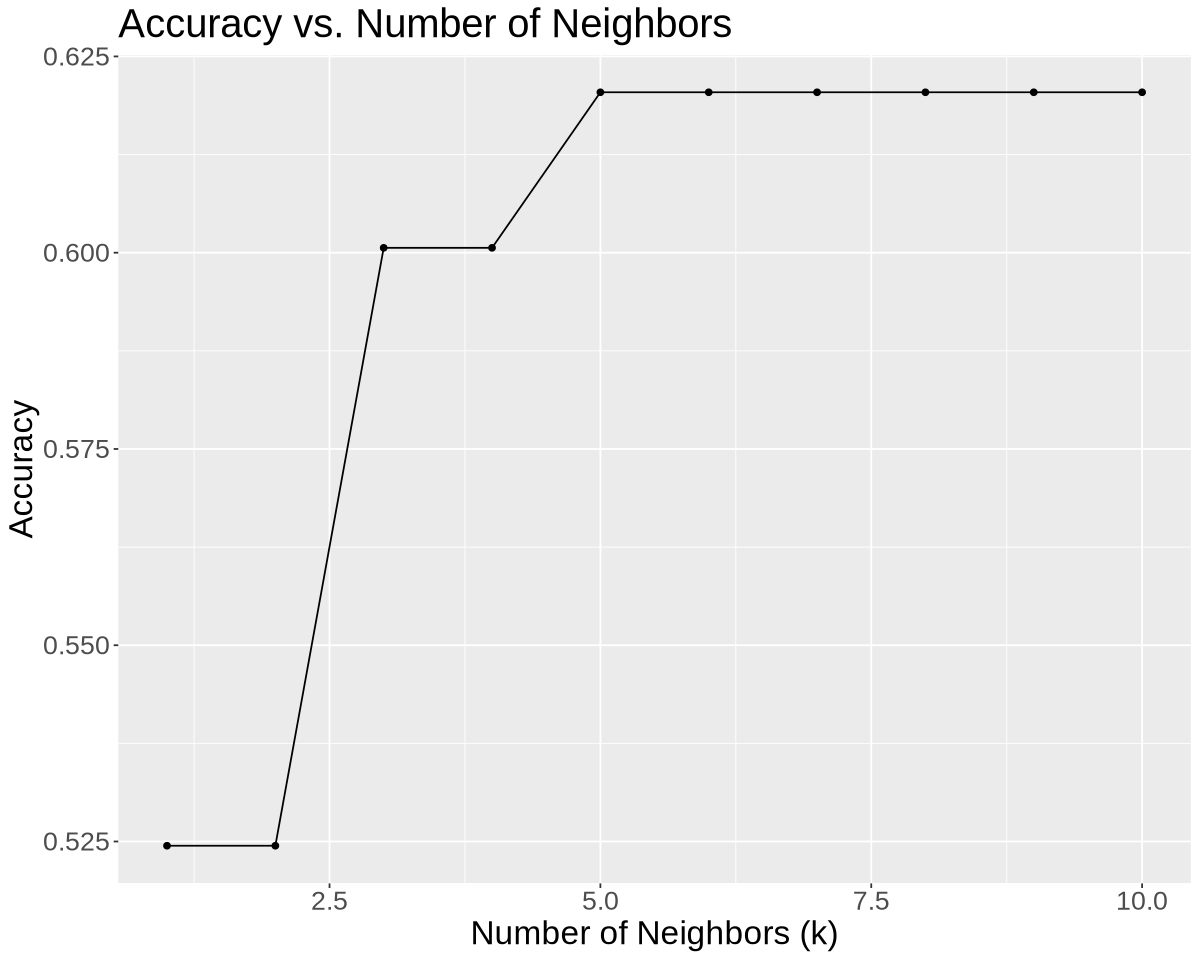

In [8]:
#sets seed
set.seed(1)

#splits data into training and testing
subscribe_split <- initial_split(combined, prop = 0.75, strata = subscribe)
subscribe_train <- training(subscribe_split)
subscribe_test <- testing(subscribe_split)

#creates model with multiple neighbors to create classification
subscribe_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                 set_engine("kknn") |>
                 set_mode("classification")

#creates recipe to scale predictors
subscribe_recipe <- recipe(subscribe ~ played_hours + number_of_sessions, data = subscribe_train) |>
                   step_scale(all_predictors()) |>
                   step_center(all_predictors())
#cross validation
subscribe_vfold <- vfold_cv(subscribe_train, v = 5, strata = subscribe)

#creates workflow
subscribe_workflow <- workflow() |>
                     add_recipe(subscribe_recipe) |>
                     add_model(subscribe_spec) 

# k values for neighbors
gridvals <- tibble(neighbors = seq(from = 1, to = 10))

# creates a table of metrics for each k value
subscribe_results <- subscribe_workflow |>
                        tune_grid(resamples = subscribe_vfold, grid = gridvals) |>
                        collect_metrics()

#filters and selects table
clean_results_subscribe <- subscribe_results |>
    filter(.metric == "accuracy") |>
    select(neighbors, mean)

#identifies neighbors with the highest accuracy value
choose_k_subscribe <- clean_results_subscribe |>
    arrange(mean) |>
    slice_max(mean, n=1) 

choose_k_subscribe

#since the highest accuracy level is the same for both neighbors = 5, 6, 7, 8, 9 and 10, we will
#graph accuracy against neighbors to have a better sense of which to pick

library(ggplot2)

plot_k <- ggplot(clean_results_subscribe, aes(x = neighbors, y = mean)) +
  geom_line() +
  geom_point() +
  labs(title = "Accuracy vs. Number of Neighbors",
       x = "Number of Neighbors (k)",
       y = "Accuracy")+
    theme(text = element_text(size = 20))

plot_k


In [9]:
#since the accuracy level semes to plateau after 5 neighbors, we will build a model based off k = 5

#creates model with the k value as 5
subscribe_spec2 <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |>
       set_engine("kknn") |>
       set_mode("classification")

#creates a new workflow to fit the training data in
subscribe_fit <- workflow() |>
             add_recipe(subscribe_recipe) |>
             add_model(subscribe_spec2) |>
            fit(data = subscribe_train)

#predict the subscription in the testing data with the trained workflow
subscribe_predictions <- predict(subscribe_fit, subscribe_test) |>
                        bind_cols(subscribe_test) 


#creates metrics for testing set (accuracy)
subscribe_metrics <- subscribe_predictions |>
  metrics(truth = subscribe, estimate = .pred_class) |>
  filter(.metric == "accuracy")

subscribe_metrics

#creates a confusion matrix for testing set
conf_mat_subscribe <- subscribe_predictions |>
        conf_mat(truth = subscribe, estimate = .pred_class)

conf_mat_subscribe

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.625


          Truth
Prediction FALSE TRUE
     FALSE     3    7
     TRUE      5   17

Discussion:
- summarize what you found
- discuss whether this is what you expected to find?
- discuss what impact could such findings have?
- discuss what future questions could this lead to?

References
You may include references if necessary, as long as they all have a consistent citation style.